In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.stats import linregress
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

import matplotlib.transforms as mtransforms
from matplotlib.patches import FancyArrowPatch

In [3]:
delE=4.5
Ka=1.4*10**(-4)
Ki=5.3*10**(-7)
K_c=Ka/Ki

custom_cmap = ListedColormap(["#FFCCCC", "#ADD8E6"])
color_list = ['r', 'orange', 'blue', 'pink']

# helper functions
def pAct(c, K_c=K_c, delE=delE):
    """ probability of repressor/activator being active

    Parameters:
        - c: inducer concentration
        - K_c: dissociation constant in active state / dissociation constant in inactive state
        - delE: energy difference between inactive and active state
    """

    p= (1 + c)**2 / ((1 + c)**2 + np.exp(-delE)*(1 + c*K_c)**2)
    return p

fixed_K = 1
fixed_r = 2
fixed_w = 7.5
fixed_gamma=1
proba=pAct(1e-6/Ka)

## Mutual Repression -  Dynamical equation

\begin{align}
\begin{split}
    \frac{d\tilde{A}}{d\tau} &= - \gamma \tilde{A} + \tilde{r}\frac{1}{1 + 2p_{act,B}\tilde{B} + \omega_B \Big(p_{act, B}\tilde{B} \Big)^2} = f(A,B) \\
    \frac{d\tilde{B}}{d\tau} &= - \tilde{B} + \tilde{r}\frac{1}{1 + 2p_{act, A}\frac{\tilde{A}}{K} + \omega_A \Big(p_{act, A}\frac{\tilde{A}}{K}\Big)^2}=g(A,B).
\end{split}
\end{align}

\begin{align}
\begin{split}
&\frac{\partial f}{\partial \tilde{A}}=  -\gamma \\
&\frac{\partial f}{\partial \tilde{B}}= -\tilde{r}\frac{2p_{act,B} (1+\omega_B p_{act,B} \tilde{B})}{\Big(1 + 2p_{act,B}\tilde{B} + \omega_B (p_{act, B}\tilde{B} )^2\Big)^2}\\
&\frac{\partial g}{\partial \tilde{A}}= -\tilde{r}\frac{2p_{act,A} (1+\omega_A p_{act,A} \tilde{A})}{\Big(1 + 2p_{act,A}\tilde{A} + \omega_A (p_{act, A}\tilde{A} )^2\Big)^2}\\
&\frac{\partial g}{\partial \tilde{B}}= -1
\end{split}
\end{align}

We choose $\gamma=1$ .



In [5]:
def partial_f_partial_A(gamma=fixed_gamma):
  return -fixed_gamma

def partial_f_partial_B(B,pactA, pactB, wA, wB, r):
  return -r*(2*pactB*(1+wB*pactB*B))/(1+2*pactB*B+wB*(pactB*B)**2)**2

def partial_g_partial_A(A,pactA, pactB, wA, wB, r):
  return -r*(2*pactA*(1+wA*pactA*A))/(1+2*pactA*A+wA*(pactA*A)**2)**2

def partial_g_partial_B():
  return -1

def det_of_jacobian(A,B,pactA, pactB, wA, wB, r):
  return partial_f_partial_A()*partial_g_partial_B() - partial_f_partial_B(B,pactA, pactB, wA, wB, r)*partial_g_partial_A(A,pactA, pactB, wA, wB, r)

In [7]:
def is_stable_mutual_repression(A, B, pactA=proba, pactB=proba, wA = fixed_w, wB = fixed_w, r = fixed_r):
  if det_of_jacobian(A,B,pactA, pactB, wA, wB, r) > 0:
    return True
  else:
    return False

def eigen_values(A, B, pactA=proba, pactB=proba, wA = fixed_w, wB = fixed_w, r = fixed_r):
  J=np.zeros((2,2))
  J[0,0]=partial_f_partial_A()
  J[0,1]=partial_f_partial_B(B,pactA, pactB, wA, wB, r)
  J[1,0]=partial_g_partial_A(A,pactA, pactB, wA, wB, r)
  J[1,1]=partial_g_partial_B()
  eigenvalues, eigenvectors = np.linalg.eig(J)
  return eigenvalues

def steady_state_A(r, K, omegaA, omegaB, pactA, pactB):
  coeff0 = -r
  coeff1 = 1 - (4 * pactA * r) / K + 2 * pactB * r + pactB**2 * r**2 * omegaB 
  coeff2 =  (4 * pactA) / K - (4 * pactA**2 * r) / K**2 + (4 * pactA * pactB * r) / K - (2 * pactA**2 * r * omegaA) / K**2
  coeff3 = (4 * pactA**2) / K**2 + (2 * pactA**2 * omegaA) / K**2 - (4 * pactA**3 * r * omegaA) / K**3 + (2 * pactA**2 * pactB * r * omegaA) / K**2
  coeff4 = (4 * pactA**3 * omegaA) / K**3 - (pactA**4 * r * omegaA**2) / K**4
  coeff5 = (pactA**4 * omegaA**2) / K**4 
  coefficients= [coeff5, coeff4, coeff3, coeff2, coeff1, coeff0]
  #coefficients=np.array([(pactA**4 * omegaB**2) / K**4,((4 * pactA**3 * omegaB) / K**3 - (pactA**4 * r * omegaB**2) / K**4), ((4 * pactA**2) / K**2 + (2 * pactA**2 * omegaB) / K**2 - (4 * pactA**3 * r * omegaB) / K**3 + (2 * pactA**2 * pactB * r * omegaB) / K**2),((4 * pactA) / K - (4 * pactA**2 * r) / K**2 + (4 * pactA * pactB * r) / K - (2 * pactA**2 * r * omegaB) / K**2),(1 - (4 * pactA * r) / K + 2 * pactB * r + pactB**2 * r**2 * omegaA),-r])
  roots=np.roots(coefficients)
  real_roots=np.real(roots[np.isreal(roots)])
  real_positive_roots = real_roots[(real_roots > 0)]
  return np.sort(real_positive_roots)

def steady_state_AB(r, K, omegaA, omegaB, pactA, pactB):
  Ass = steady_state_A(r, K, omegaA, omegaB, pactA, pactB)
  Bss = r/(1+2*pactA*Ass/K+omegaA*(pactA*Ass/K)**2)
  return Ass, Bss

In [9]:
def mut_rep_R1_R2_t_profile(initial_conditions, p1=pAct(1e-6*Ka), p2=pAct(1e-6*Ka), w1=fixed_w, w2=fixed_w, r=fixed_r, K=fixed_K, tmax =100):
  def system(t, vars):
    R1, R2 = vars
    dR1_dt = -R1 + r / (1 + 2 * p2 * R2 + ((p2 * R2)**2) * w2)
    dR2_dt = -R2 + r / (1 + 2 * p1 * (R1 / K) + ((p1 * (R1 / K))**2) * w1)
    return [dR1_dt, dR2_dt]
  t_span = (0, tmax)  
  t_eval = np.linspace(0, tmax, 2000) 
  solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, method='RK45')
  R1_of_t = solution.y[0]
  R2_of_t = solution.y[1]
  time = solution.t

  return R1_of_t, R2_of_t, time

In [11]:
def time_scale_mut(ss1,ss2,f1_of_t,f2_of_t,time,thresh=0.9,steady_state_ode=0):
#   """ steady_state_ode : boolean, 0 if the the steady state is computed from an analytical equation
#                                   1 if the steady state is computed from solving ode""" 
    
  f1_0, f2_0 = f1_of_t[0], f2_of_t[0]
  f1_inf, f2_inf = f1_of_t[-1], f2_of_t[-1]
  t_0=time[0]
  if not steady_state_ode:
      i_ss = np.argmin(np.abs(f1_inf-ss1))
      f1ss, f2ss = ss1[i_ss], ss2[i_ss]
  if steady_state_ode:
      f1ss, f2ss = f1_inf, f2_inf
  distinf_1 = np.abs(f1_inf - f1ss )
  distinf_2 = np.abs(f2_inf - f2ss )
  disti_1 = distinf_1
  disti_2 = distinf_2
  i_t = len(time)-1
  dist_thresh_1 = (1-thresh)*f1ss
  dist_thresh_2 = (1-thresh)*f2ss 
  while (disti_1 < dist_thresh_1 or disti_2 < dist_thresh_2) and i_t>0:
    i_t-=1 
    disti_1 = np.abs(f1ss-f1_of_t[i_t])
    disti_2 = np.abs(f2ss-f2_of_t[i_t])
  return time[i_t]

In [13]:
def time_heat_map(R1_fixed_points, R2_fixed_points, log10R0min=-2, log10R0max=1, n=50, tmax=100, thresh=0.9,p1=pAct(1e-6*Ka), p2=pAct(1e-6*Ka), w1=fixed_w, w2=fixed_w, r=fixed_r, K=fixed_K):
  R0_list_i=np.logspace(log10R0min , log10R0max, n)
  tau_R1_R2_list_2d_i = np.zeros((n,n))

  for i1 in range(n):
    R01=R0_list_i[i1]
    for i2 in range(n):
      R02=R0_list_i[i2]
      R0=[R01,R02]
      R1_of_t, R2_of_t, time = mut_rep_R1_R2_t_profile(R0,tmax=tmax,p1=p1, p2=p2, w1=w1, w2=w2, r=r, K=K)
      tau_R1_R2_i = time_scale_mut(R1_fixed_points, R2_fixed_points, R1_of_t, R2_of_t, time,thresh=thresh)
      tau_R1_R2_list_2d_i[i1,i2] = tau_R1_R2_i
  return tau_R1_R2_list_2d_i

In [15]:
def separatrix_heat_map(R1_fixed_points, R2_fixed_points, log10R0min=-2, log10R0max=1, n=50, tmax=100, p1=pAct(1e-6*Ka), p2=pAct(1e-6*Ka), w1=fixed_w, w2=fixed_w, r=fixed_r, K=fixed_K):
  R0_list=np.logspace(log10R0min , log10R0max, n)
  steady_state_1_or_2 = np.zeros((n,n))

  for i1 in range(n):
    R01=R0_list[i1]
    for i2 in range(n):
      R02=R0_list[i2]
      R0=[R01,R02]
      R1_of_t, R2_of_t, time = mut_rep_R1_R2_t_profile(R0,tmax=tmax, p1=p1, p2=p2, w1=w1, w2=w2, r=r, K=K)
      R1ss, R2ss = R1_of_t[-1], R2_of_t[-1]
      iss1, iss2 = np.argmin(np.abs(R1_fixed_points - R1ss)), np.argmin(np.abs(R2_fixed_points - R2ss))
      if iss1 == 0 and iss2 == 0:
        steady_state_1_or_2[i1,i2] = 1
      elif iss1 == 2 and iss2 == 2:
        steady_state_1_or_2[i1,i2] = 0
  return steady_state_1_or_2

In [17]:
def separatrix_ode(sepatrix_cat , p1=pAct(1e-6*Ka), p2=pAct(1e-6*Ka), w1=fixed_w, w2=fixed_w, r=fixed_r, K=fixed_K,gamma=fixed_gamma, A_span = (0.01, 10)):
    A_vals = np.logspace(np.log10(A_span[0]), np.log10(A_span[1]), 400)
    
    def ode_dBdA(A, B):
        denominator_f = 1 + 2 * p2 * B + w1 * (p2 * B) ** 2
        f = -gamma * A + r / denominator_f
        term = p1 * A / K
        denominator_g = 1 + 2 * term + w2 * term ** 2
        g = -B + r / denominator_g
        return g/f 

    def ode_dAdB(B, A):
        denominator_f = 1 + 2 * p2 * B + w1 * (p2 * B) ** 2
        f = -gamma * A + r / denominator_f
        term = p1 * A / K
        denominator_g = 1 + 2 * term + w2 * term ** 2
        g = -B + r / denominator_g
        return f/g    
        
    all_B_for_A_0 = sepatrix_cat[:,0]
    R0 = np.logspace(np.log10(A_span[0]), np.log10(A_span[1]), len(sepatrix_cat))
    indice_sep = np.where(np.diff(all_B_for_A_0) != 0)[0]
    if indice_sep.size > 0 :
        B0 = [(R0[indice_sep[0]]+R0[indice_sep[0]+1])/2]
        solution = solve_ivp(ode_dBdA, A_span, B0, t_eval = A_vals, method='RK45')
        B_sol = solution.y[0]
        A_sol = solution.t
    else :
        all_A_for_B_0 = sepatrix_cat[0,:]
        indice_sep = np.where(np.diff(all_A_for_B_0) != 0)[0]
        A0 = [(R0[indice_sep[0]]+R0[indice_sep[0]+1])/2]
        print(A0[0])
        solution = solve_ivp(ode_dAdB, A_span, A0, t_eval = A_vals, method='RK45')
        A_sol = solution.y[0]
        B_sol = solution.t
    return A_sol, B_sol

In [19]:
def steady_state_heat_map( log10R0min=-2, log10R0max=1, n=50, tmax=100, p1=pAct(1e-6*Ka), p2=pAct(1e-6*Ka), w1=fixed_w, w2=fixed_w, r=fixed_r, K=fixed_K):
  R0_list=np.logspace(log10R0min , log10R0max, n)
  steady_state_R1 = np.zeros((n,n))
  steady_state_R2 = np.zeros((n,n))

  for i1 in range(n):
    R01=R0_list[i1]
    for i2 in range(n):
      R02=R0_list[i2]
      R0=[R01,R02]
      R1_of_t, R2_of_t, time = mut_rep_R1_R2_t_profile(R0,tmax=tmax, p1=p1, p2=p2, w1=w1, w2=w2, r=r, K=K)
      R1ss, R2ss = R1_of_t[-1], R2_of_t[-1]
      steady_state_R1[i1,i2] = R1ss
      steady_state_R2[i1,i2] = R2ss
  return steady_state_R1, steady_state_R2

## Fully symetric case $K=1$, $\omega_1=\omega_2=7.5$, $r=2$.

In [21]:
R1_fixed_points,R2_fixed_points = steady_state_AB(fixed_r,fixed_K, fixed_w, fixed_w, pAct(1e-6/Ka), pAct(1e-6/Ka))

In [23]:
steady_state_1_or_2_sym=separatrix_heat_map(R1_fixed_points, R2_fixed_points,n=200)

In [25]:
tau_R1_R2_list_2d_sym=time_heat_map(R1_fixed_points, R2_fixed_points,tmax=100,thresh=0.95,n=200)

In [27]:
sep_curve=separatrix_ode(np.transpose(steady_state_1_or_2_sym))

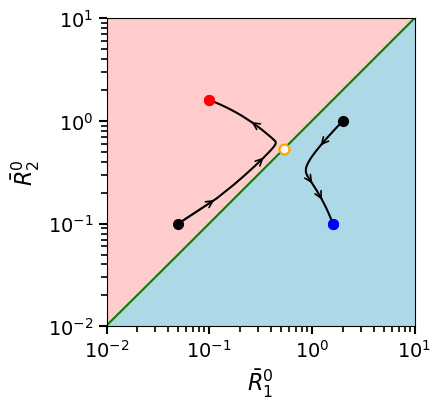

In [31]:
log10R0min,log10R0max=-2,1
R0=np.logspace(log10R0min,log10R0max,200)
R01,R02 = np.meshgrid(R0,R0)
init_list = [[0.05,0.1],[2,1]]
fig, ax = plt.subplots(1, 1, figsize=(4,4))
c2 = ax.pcolormesh(R01,R02,steady_state_1_or_2_sym, cmap=custom_cmap)
ax.plot(sep_curve[0],sep_curve[1],'g')
i=0
for init in init_list:
    R1t,R2t,time = mut_rep_R1_R2_t_profile(init, p1=pAct(1e-6/Ka), p2=pAct(1e-6/Ka), w1=fixed_w, w2=fixed_w, r=fixed_r, K=fixed_K, tmax =100)
    ax.plot([init[0]],[init[1]], color = 'k', marker='o', markersize=7)
    ax.plot(R1t,R2t,'k')
    ax.set_xlim(10**log10R0min, 10**log10R0max)
    ax.set_ylim(10**log10R0min, 10**log10R0max)
    for iss in range(len(R1_fixed_points)):
        rss1=R1_fixed_points[iss]
        rss2=R2_fixed_points[iss]
        stable = is_stable_mutual_repression(rss1, rss2)
        if stable:
          ax.plot([rss1],[rss2], color = color_list[iss], marker='o', markersize=7)
        else:
          ax.plot([rss1],[rss2], color = color_list[iss], marker='o', markersize=7, markerfacecolor='white', markeredgewidth=1.5)

    #plot arrows
    log_R1t = np.log10(R1t)
    log_R2t = np.log10(R2t)
    

    dists = np.sqrt(np.diff(log_R1t)**2 + np.diff(log_R2t)**2)
    arc_length = np.concatenate([[0], np.cumsum(dists)])
    total_length = arc_length[-1]
    
    if i==0:
        targets = [0.25 * total_length, 0.5 * total_length, 0.75 * total_length]
    else: 
        targets = [0.25 * total_length, 0.6 * total_length, 0.75 * total_length]
    
    arrow_indices = [np.argmin(np.abs(arc_length - t)) for t in targets]
    
    for idx in arrow_indices:
        if idx <= 0 or idx >= len(R1t) - 1:
            continue
        x_start, y_start = R1t[idx - 1], R2t[idx - 1]
        x_end, y_end = R1t[idx], R2t[idx]
    
        arrow = FancyArrowPatch((x_start, y_start), (x_end, y_end),
                                arrowstyle='->', mutation_scale=12,
                                color='k', linewidth=1.2)
        ax.add_patch(arrow)

    i+=1
ax.set_aspect('equal')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\bar{R}^0_{1}$', fontsize=16)
ax.set_ylabel(r'$\bar{R}^0_{2}$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14, width=1.5, length=6)
ax.tick_params(axis='both', which='minor', labelsize=12, width=1.2, length=4)

0.0 35.71785892946473


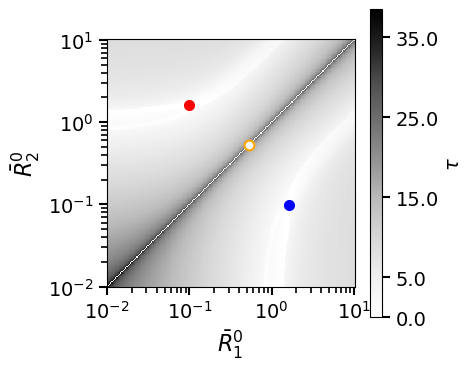

In [37]:
log10R0min,log10R0max=-2,1
R0=np.logspace(log10R0min,log10R0max,200)
R01,R02 = np.meshgrid(R0,R0)
init_list = [[0.05,0.1],[2,1]]
fig, ax = plt.subplots(1, 1, figsize=(4,4))
c1 = ax.pcolormesh(R01,R02,tau_R1_R2_list_2d_sym, cmap='Grays',rasterized=True,vmax=38.519259629814904) # to have the same color map for asym and sym
#ax.plot(sep_curve[0],sep_curve[1],'g',lw=1.3)

for iss in range(len(R1_fixed_points)):
    rss1=R1_fixed_points[iss]
    rss2=R2_fixed_points[iss]
    stable = is_stable_mutual_repression(rss1, rss2)
    if stable:
      ax.plot([rss1],[rss2], color = color_list[iss], marker='o', markersize=7)
    else:
      ax.plot([rss1],[rss2], color = color_list[iss], marker='o', markersize=7, markerfacecolor='white', markeredgewidth=1.5)

ax.set_aspect('equal')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\bar{R}^0_{1}$', fontsize=16)
ax.set_ylabel(r'$\bar{R}^0_{2}$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14, width=1.5, length=6)
ax.tick_params(axis='both', which='minor', labelsize=12, width=1.2, length=4)

print(np.min(tau_R1_R2_list_2d_sym),np.max(tau_R1_R2_list_2d_sym))
cbar = fig.colorbar(c1, ax=ax, label=r'$\tau$', shrink=1, aspect=25)
cbar.ax.set_ylabel(r'$\tau$', fontsize=14)
cbar.ax.tick_params(axis='y', which='major', labelsize=14, width=1.5, length=6)
cbar.ax.tick_params(axis='y', which='minor', labelsize=12, width=1.2, length=4)
tick_vals = np.array([0,5,15,25,35])
cbar.set_ticks(tick_vals)
cbar.ax.set_yticklabels([f"{val:.1f}" for val in tick_vals])
plt.show()
#folder = '/Users/saramahdavi/Documents/pAct/mutual repression'
#plt.savefig(folder+'/dynamics_mutual_timescale_symetric.pdf')

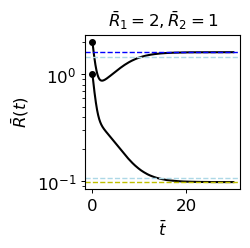

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))
thresh0=0.9
init = [2,1]
R1t,R2t,time = mut_rep_R1_R2_t_profile(init, p1=pAct(1e-6/Ka), p2=pAct(1e-6/Ka), w1=fixed_w, w2=fixed_w, r=fixed_r, K=fixed_K, tmax =30)
ax.plot(time,R1t,'k')
ax.plot(time,R2t,'k')
ax.set_yscale('log')
ax.plot([0],[init[0]], color = 'k', marker='o', markersize=4)
ax.plot([0],[init[1]], color = 'k', marker='o', markersize=4)
ax.axhline(y=R1_fixed_points[0], color='y', linestyle='--', linewidth=1)
ax.axhline(y=R2_fixed_points[0], color='b', linestyle='--', linewidth=1)

ax.axhline(y=R1_fixed_points[0]*(1+(1-thresh0)), color='lightblue', linestyle='--', linewidth=1)

ax.axhline(y=R2_fixed_points[0]*(thresh0), color='lightblue', linestyle='--', linewidth=1)

ax.set_xlabel(r'$\bar{t}$', fontsize=12)
ax.set_ylabel(r'$\bar{R}(t)$', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12, width=0.7, length=3)
ax.tick_params(axis='both', which='minor', labelsize=12, width=0.6, length=2)
ax.set_title(r'$\bar{R}_1=2, \bar{R}_2=1$')
plt.show()

In [146]:
#plot_grid_timescales(size_of_grid=5, thresh=0.9, tmax=50, p1=pAct(1e-3), p2=pAct(1e-2))

In [41]:
#p1_K07, p2_K07 = pAct(1e-7/Ka), pAct(1e-6/Ka)
pAct1,pAct2 = pAct(1e-3), pAct(1e-2)
R1_fixed_points,R2_fixed_points= steady_state_AB(fixed_r, fixed_K, fixed_w, fixed_w, pAct1, pAct2)
steady_state_1_or_2=separatrix_heat_map(R1_fixed_points, R2_fixed_points,n=100, p1=pAct1, p2=pAct2, w1=fixed_w, w2=fixed_w, r=fixed_r, K=fixed_K)

In [43]:
tau_R1_R2_list_2d=time_heat_map(R1_fixed_points, R2_fixed_points, p1=pAct1, p2=pAct2, w1=fixed_w, w2=fixed_w, r=fixed_r, K=fixed_K, tmax=100,thresh=0.95)

In [45]:
sep_curve=separatrix_ode(np.transpose(steady_state_1_or_2), p1=pAct(1e-3), p2=pAct(1e-2))

In [47]:
plot_heat_map_tau_and_separatrix(np.transpose(tau_R1_R2_list_2d), np.transpose(steady_state_1_or_2),sep_curve, R1_fixed_points, R2_fixed_points)
#plt.savefig(folder+'/dynamics_mutual_repression_K=1_gamma=1_omega1=omega2=7pt5_r=2_pactAneqpactB.pdf')

NameError: name 'plot_heat_map_tau_and_separatrix' is not defined

## $K=1$, $\omega_1=50$ $\omega_2=7.5$, $p_{act}^A\neq p_{act}^B$.


In [288]:
omega1=50
omega2=fixed_w
pAct1,pAct2=pAct(5*1e-6/Ka), pAct(1e-6/Ka)

In [390]:
R1_fixed_points,R2_fixed_points = steady_state_AB(fixed_r, fixed_K, omega1,omega2, pAct1, pAct2)

In [292]:
tau_R1_R2_list_2d_asym = time_heat_map(R1_fixed_points,R2_fixed_points,  p1=pAct1, p2=pAct2, w1=omega1, w2=omega2, r=fixed_r, K=1, tmax=100,thresh=0.95,n=200)

In [293]:
steady_state_1_or_2_a = separatrix_heat_map(R1_fixed_points,R2_fixed_points,n=100, p1=pAct1, p2=pAct2, w1=omega1, w2=omega2, r=fixed_r, K=1)
ss_cat_a=np.transpose(steady_state_1_or_2_a)
sep_curve_a = separatrix_ode(ss_cat_a, p1=pAct1, p2=pAct2, w1=omega1, w2=omega2)

0.0 38.519259629814904


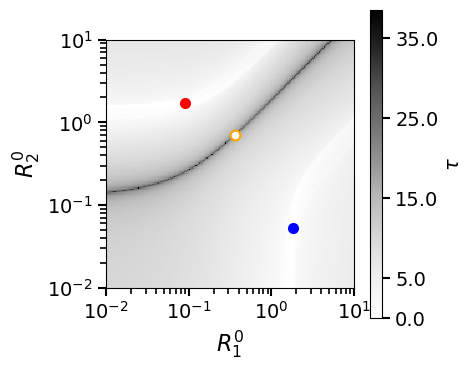

In [394]:
log10R0min,log10R0max=-2,1
R0=np.logspace(log10R0min,log10R0max,200)
R01,R02 = np.meshgrid(R0,R0)
init_list = [[0.05,0.1],[2,1]]
fig, ax = plt.subplots(1, 1, figsize=(4,4))
c1 = ax.pcolormesh(R01,R02,np.transpose(tau_R1_R2_list_2d_asym), cmap='Grays')

for iss in range(len(R1_fixed_points)):
    rss1=R1_fixed_points[iss]
    rss2=R2_fixed_points[iss]
    stable = is_stable_mutual_repression(rss1, rss2)
    if stable:
      ax.plot([rss1],[rss2], color = color_list[iss], marker='o', markersize=7)
    else:
      ax.plot([rss1],[rss2], color = color_list[iss], marker='o', markersize=7, markerfacecolor='white', markeredgewidth=1.5)
cbar = fig.colorbar(c1, ax=ax, label=r'$\tau$', shrink=1, aspect=25)
cbar.ax.set_ylabel(r'$\tau$', fontsize=14)
cbar.ax.tick_params(axis='y', which='major', labelsize=14, width=1.5, length=6)
cbar.ax.tick_params(axis='y', which='minor', labelsize=12, width=1.2, length=4)
tick_vals = np.array([0,5,15,25,35])
cbar.set_ticks(tick_vals)
cbar.ax.set_yticklabels([f"{val:.1f}" for val in tick_vals])
ax.set_xlim(10**log10R0min, 10**log10R0max)
ax.set_ylim(10**log10R0min, 10**log10R0max)
ax.set_aspect('equal')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$R^0_{1}$', fontsize=16)
ax.set_ylabel(r'$R^0_{2}$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14, width=1.5, length=6)
ax.tick_params(axis='both', which='minor', labelsize=12, width=1.2, length=4)
print(np.min(tau_R1_R2_list_2d_asym),np.max(tau_R1_R2_list_2d_asym))
folder = '/Users/saramahdavi/Documents/pAct/mutual repression'
plt.savefig(folder+'/dynamics_mutual_timescale_asymetric.pdf')

In [383]:
omega2=fixed_w
omega1=50
pAct2,pAct1=pAct(5*1e-6/Ka), pAct(1e-6/Ka)

In [217]:
#plot_grid_timescales(size_of_grid=5, thresh=0.9, tmax=50, p1=pAct1, p2=pAct2, w1=omega1, w2=omega2, logR0_min=np.log10(0.07),logR0_max=np.log10(2) )

In [385]:
R1_fixed_points,R2_fixed_points = steady_state_AB(fixed_r, fixed_K, omega1,omega2, pAct1,pAct2)
R1_fixed_points,R2_fixed_points

(array([0.05196854, 0.76612552, 1.67014662]),
 array([1.79998678, 0.34163391, 0.09776539]))

In [387]:
tau_R1_R2_list_2d=time_heat_map(R1_fixed_points,R2_fixed_points,  p1=pAct1, p2=pAct2, w1=omega1, w2=omega2, r=fixed_r, K=1, tmax=100,thresh=0.9)
steady_state_1_or_2=separatrix_heat_map(R1_fixed_points,R2_fixed_points,n=100, p1=pAct1, p2=pAct2, w1=omega1, w2=omega2, r=fixed_r, K=1)

In [397]:
sep_curve = separatrix_ode(np.transpose(steady_state_1_or_2), p1=pAct1, p2=pAct2, w1=omega1, w2=omega2)

0.1810672911434034


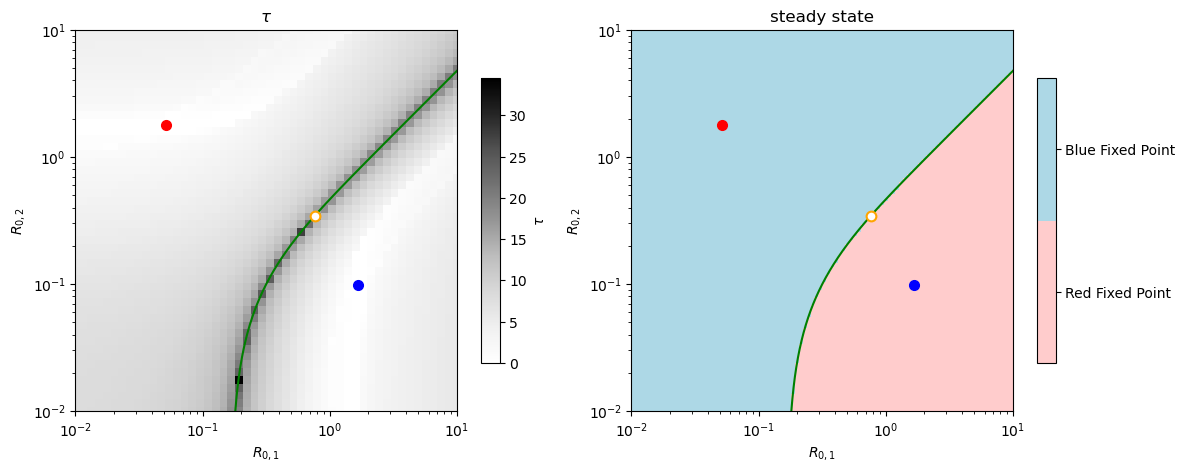

In [401]:
plot_heat_map_tau_and_separatrix(np.transpose(tau_R1_R2_list_2d), np.transpose(steady_state_1_or_2), sep_curve, R1_fixed_points,R2_fixed_points)
plt.savefig(folder+'/dynamics_mutual_repression_K=1_gamma=1_omega1=50_omega2=7pt5_r=2_pactAneqpactB.pdf')

In [ ]:
n=100

R0_list=np.logspace(-2 , 1, n)

tau_R1_cf_list = np.zeros(n)
tau_R1_63_list = np.zeros(n)

tau_R2_cf_list = np.zeros(n)
tau_R2_63_list = np.zeros(n)

for i1 in range(n):
  R01=R0_list[i1]
  R0=[R01,R01]
  R1_of_t, R2_of_t, time = mut_rep_R1_R2_t_profile(R0)

  #tau_R1_cf = time_scale(R1_fixed_points,R1_of_t,time,type_of_approach='curve_fit')
  tau_R1_63 = time_scale(R1_fixed_points,R1_of_t,time,type_of_approach='63%')
  #tau_R1_cf_list[i1] = tau_R1_cf
  tau_R1_63_list[i1] = tau_R1_63

  #tau_R2_cf = time_scale(R2_fixed_points,R2_of_t,time,type_of_approach='curve_fit')
  tau_R2_63 = time_scale(R2_fixed_points,R2_of_t,time,type_of_approach='63%')
  #tau_R2_cf_list[i1] = tau_R2_cf
  tau_R2_63_list[i1] = tau_R2_63

plt.figure()


#plt.plot(R0_list,tau_R1_cf_list, 'k', label = 'curve fit')
plt.plot(R0_list,tau_R1_63_list, 'k.', label = '63%')
plt.xlabel('initial concentration of gene R1')
plt.ylabel('timescale to relax to steady state for R1')
plt.xscale('log')
plt.yscale('log')





for iss in range(len(R1_fixed_points)):
  rss1=R1_fixed_points[iss]
  rss2=R2_fixed_points[iss]
  stable = is_stable_mutual_repression(rss1, rss2)
  if stable:
    ls = '-'
  else:
    ls = '--'
  plt.axvline(rss1, color = color_list[iss], linestyle=ls)

plt.axhline(1,color='gray', label=r'$\gamma$')

plt.legend()
plt.show()

plt.figure()

#plt.plot(R0_list,tau_R2_cf_list, 'k', label = 'curve fit')
plt.plot(R0_list,tau_R2_63_list, 'k.', label = '63%')
plt.xlabel('initial concentration of gene R2')
plt.ylabel('timescale to relax to steady state for R2')
plt.xscale('log')
plt.yscale('log')

for iss in range(len(R1_fixed_points)):
  rss1=R1_fixed_points[iss]
  rss2=R2_fixed_points[iss]
  stable = is_stable_mutual_repression(rss1, rss2)
  if stable:
    ls = '-'
  else:
    ls = '--'
  plt.axvline(rss2, color = color_list[iss], linestyle=ls)

plt.axhline(1,color='gray', label=r'$\gamma$')

plt.legend()

In [ ]:
R0_list = np.logspace(0, 1, 10)
color_list = ['r', 'orange', 'blue', 'pink']
R0_list50 = np.logspace(-2, 1, 50)
R100,R200=np.meshgrid(R0_list50,R0_list50)


#ax.contour(R100,R200,steady_state_1_or_2)
for R01 in R0_list:
    fig, ax = plt.subplots(1,1, sharey=True, sharex=True, figsize=(4, 4))
    R0=[R01,R01]
    R1_of_t, R2_of_t, time = mut_rep_R1_R2_t_profile(R0)
    ax.plot(R1_of_t, R2_of_t, 'k.', label=f'R0={R0}')
    ax.scatter([R1_of_t[0]], [R2_of_t[0]], color='k')
    for iss in range(len(R1_fixed_points)):
      rss1=R1_fixed_points[iss]
      rss2=R2_fixed_points[iss]
      stable = is_stable_mutual_repression(rss1, rss2)
      if stable:
        m = 'o'
      else:
        m = '+'
      ax.plot([rss1],[rss2], color = color_list[iss], marker=m)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_aspect('equal')




    ax.set_xlabel('concentration of gene R1')
    ax.set_ylabel('concentration of gene R2')

plt.show()

In [ ]:
R0_list = np.logspace(-2, 1, 5)
color_list = ['r', 'orange', 'blue', 'pink']
R0_list50 = np.logspace(-2, 1, 50)
R100,R200=np.meshgrid(R0_list50,R0_list50)

fig, ax = plt.subplots(1,1, sharey=True, sharex=True, figsize=(4, 4))
#ax.contour(R100,R200,steady_state_1_or_2)
for R01 in R0_list:
  for R02 in R0_list:
    fig, ax = plt.subplots(1,1, sharey=True, sharex=True, figsize=(4, 4))
    R0=[R01,R02]
    R1_of_t, R2_of_t, time = mut_rep_R1_R2_t_profile(R0)
    ax.plot(R1_of_t, R2_of_t, 'k', label=f'R0={R0}')
    ax.scatter([R1_of_t[0]], [R2_of_t[0]], color='k')
    for iss in range(len(R1_fixed_points)):
      rss1=R1_fixed_points[iss]
      rss2=R2_fixed_points[iss]
      stable = is_stable_mutual_repression(rss1, rss2)
      if stable:
        m = 'o'
      else:
        m = '+'
      ax.plot([rss1],[rss2], color = color_list[iss], marker=m)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_aspect('equal')




    ax.set_xlabel('concentration of gene R1')
    ax.set_ylabel('concentration of gene R2')

plt.show()

In [ ]:
R0_plot_list = [[0.4,0.01],[0.01,0.4],[1,0.1],[0.1,1],[0.3,0.3],[1,0.3],[0.3,1],[1,1]][:5]
R0_plot_list = [[0.3,0.3],[0.5,0.5],[1,1],[3,3],[10,10]]
color_list = ['r', 'orange', 'blue', 'pink']

fig, ax = plt.subplots(1,5, sharey=True, sharex=True, figsize=(20, 4))
i=0
for R0 in R0_plot_list:
    R1_of_t, R2_of_t, time = mut_rep_R1_R2_t_profile(R0)
    ax[i].plot(R1_of_t, R2_of_t, 'k.', label=f'R0={R0}')


    for iss in range(len(R1_fixed_points)):
      rss1=R1_fixed_points[iss]
      rss2=R2_fixed_points[iss]
      stable = is_stable_mutual_repression(rss1, rss2)
      if stable:
        m = 'o'
      else:
        m = '+'
      ax[i].plot([rss1],[rss2], color = color_list[iss], marker=m)

    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_aspect('equal')


    ax[i].legend()
    i+=1

ax[0].set_xlabel('concentration of gene R1')
ax[0].set_ylabel('concentration of gene R2')

plt.show()

In [ ]:
R0_plot_list = [0.01, 0.1, 0.7, 1.4, 10]
color_list = ['r', 'orange', 'blue', 'pink']

fig, ax = plt.subplots(1,5, sharey=True, sharex=True, figsize=(20, 4))
i=0
for R0 in R0_plot_list:
    R1_of_t, R2_of_t, time = mut_rep_R1_R2_t_profile([R0, R0])
    ax[i].plot(R1_of_t, R2_of_t, 'k', label=f'R0={R0}')


    for iss in range(len(R1_fixed_points)):
      rss1=R1_fixed_points[iss]
      rss2=R2_fixed_points[iss]
      stable = is_stable_mutual_repression(rss1, rss2)
      if stable:
        m = 'o'
      else:
        m = '+'
      ax[i].plot([rss1],[rss2], color = color_list[iss], marker=m)

    ax[i].set_xscale('log')
    ax[i].set_yscale('log')


    ax[i].legend()
    i+=1

ax[0].set_xlabel('concentration of gene R1')
ax[0].set_ylabel('concentration of gene R2')

plt.show()

In [ ]:
R0_plot_list = [[1,0.1],[0.1,1]]
color_list = ['r', 'orange', 'blue', 'pink']

color_list2 = ['k', 'pink', 'gray', 'green']
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

i=0
for R0 in R0_plot_list:
    R1_of_t, R2_of_t, time = mut_rep_R1_R2_t_profile(R0)
    ax1.plot(time, R1_of_t, color_list2[i], label=f'R0={R0}')
    ax2.plot(time, R2_of_t, color_list2[i], label=f'R0={R0}')
    i+=1

for iss in range(len(R1_fixed_points)):
  rss1=R1_fixed_points[iss]
  rss2=R2_fixed_points[iss]
  stable = is_stable_mutual_repression(rss1, rss2)
  if stable:
    ls = '-'
  else:
    ls = '--'
  ax1.axhline(rss1, color = color_list[iss], linestyle=ls)
  ax2.axhline(rss2, color = color_list[iss], linestyle=ls)

ax1.set_xlabel('time')
ax1.set_ylabel('concentration of gene R1')
ax2.set_xlabel('time')
ax2.set_ylabel('concentration of gene R2')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')

ax1.legend()
ax2.legend()

plt.show()
